In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import re

In [2]:
import numpy as np
import seaborn as sns
import matplotlib
import scipy
print(f"NumPy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

NumPy version: 2.1.3
Seaborn version: 0.13.2
SciPy version: 1.14.1
matplotlib version: 3.9.3


In [3]:
import nltk

nltk.download("wordnet")
nltk.download("punkt")
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /Users/angwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/angwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angwang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angwang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/angwang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Load Data
train = pd.read_csv('../public_data/train/track_a/eng.csv')
val = pd.read_csv('../public_data/dev/track_a/eng_a.csv')
emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_16708/1728478088.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=emotion_colors.values())


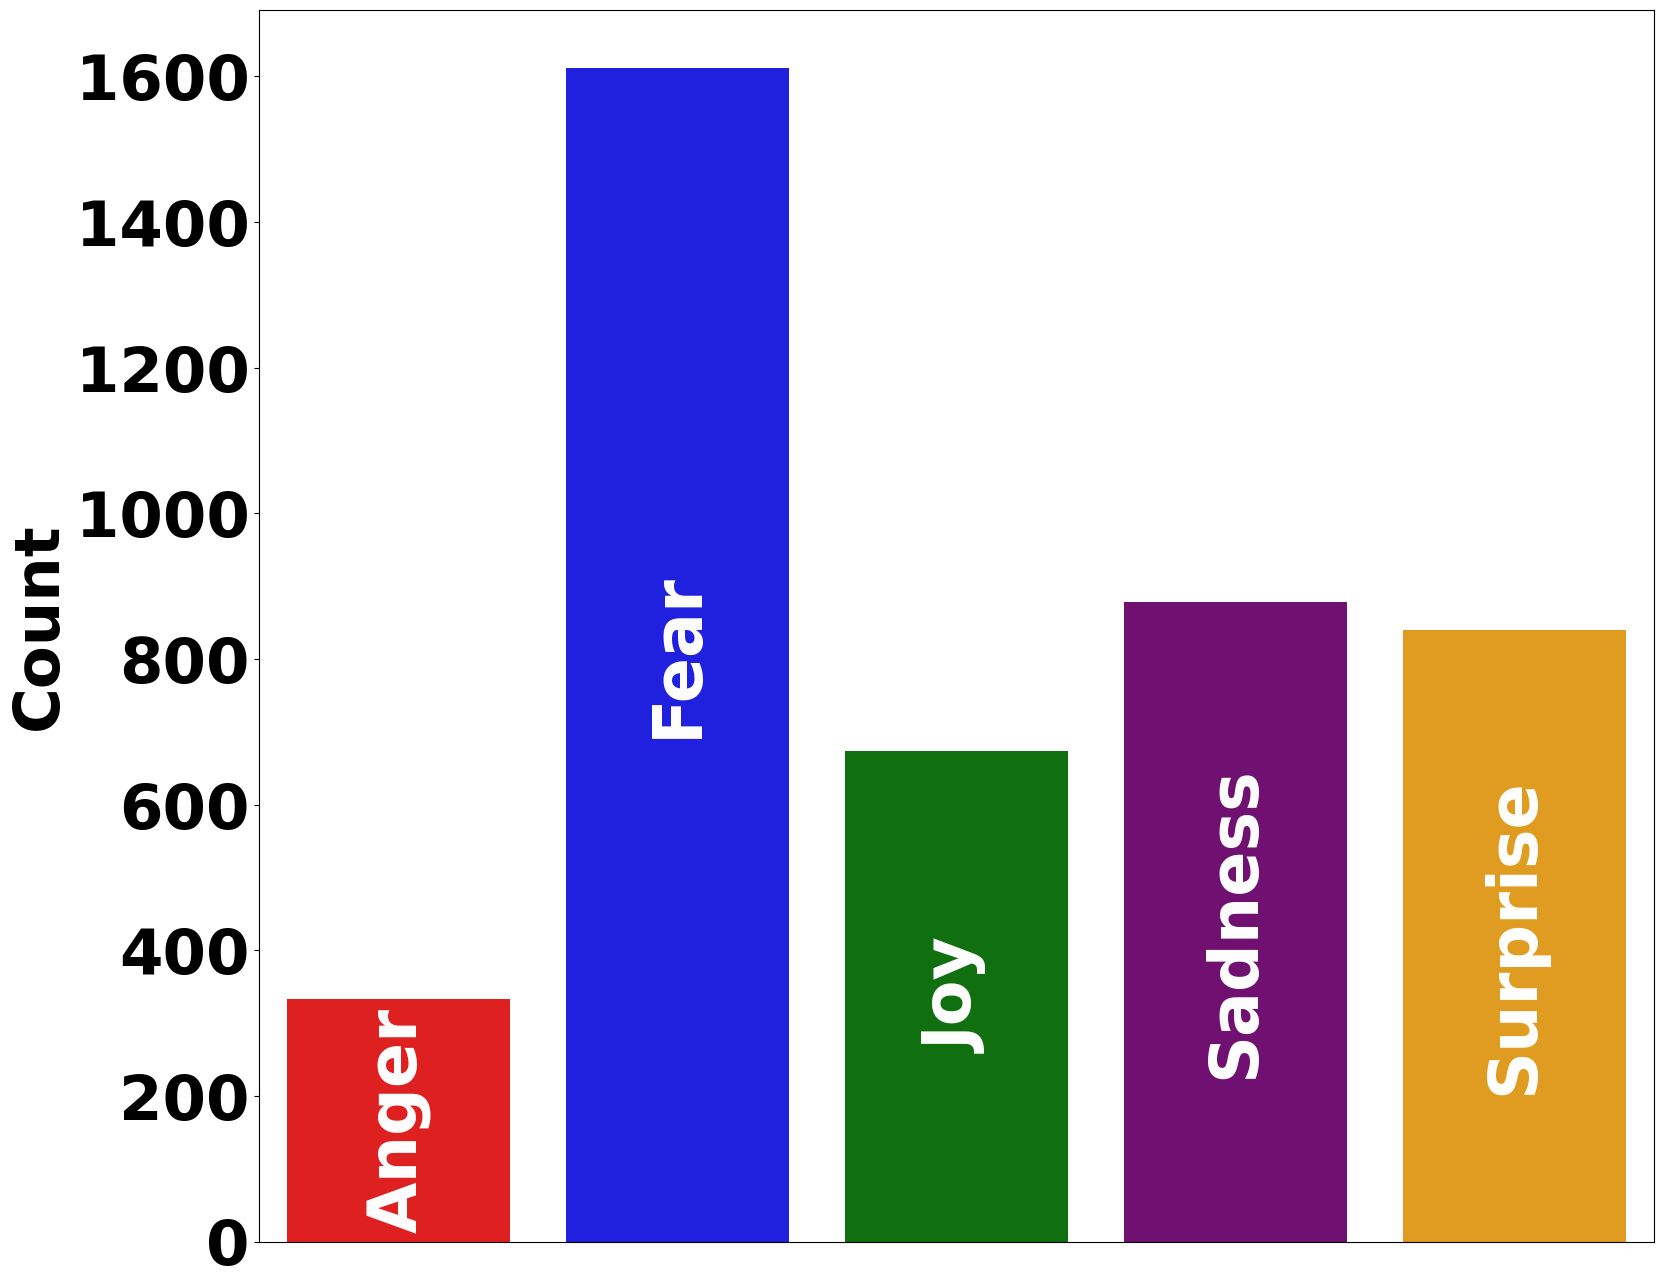

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
emotions = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
class_counts = train[emotions].sum()

# Define custom colors for each emotion
emotion_colors = {
    'Anger': 'red',
    'Fear': 'blue',
    'Joy': 'green',
    'Sadness': 'purple',
    'Surprise': 'orange'
}

# Plot the distribution
plt.figure(figsize=(18, 16))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=emotion_colors.values())

# Add vertical labels inside bars
for i, v in enumerate(class_counts.values):
    ax.text(i, v/2, class_counts.index[i], 
            color='white', 
            ha='center',
            va='center',
            fontsize=48,
            fontweight='bold',
            rotation=90)  # Add rotation for vertical text

plt.title("")
plt.xlabel("")
plt.ylabel("Count", fontsize=45, fontweight='bold')
plt.xticks([])  # Remove x-axis labels since we have them in bars
plt.yticks(fontsize=45, weight='bold')
plt.show()

/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_16708/1949300458.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=normalized_counts.index, y=normalized_counts.values,


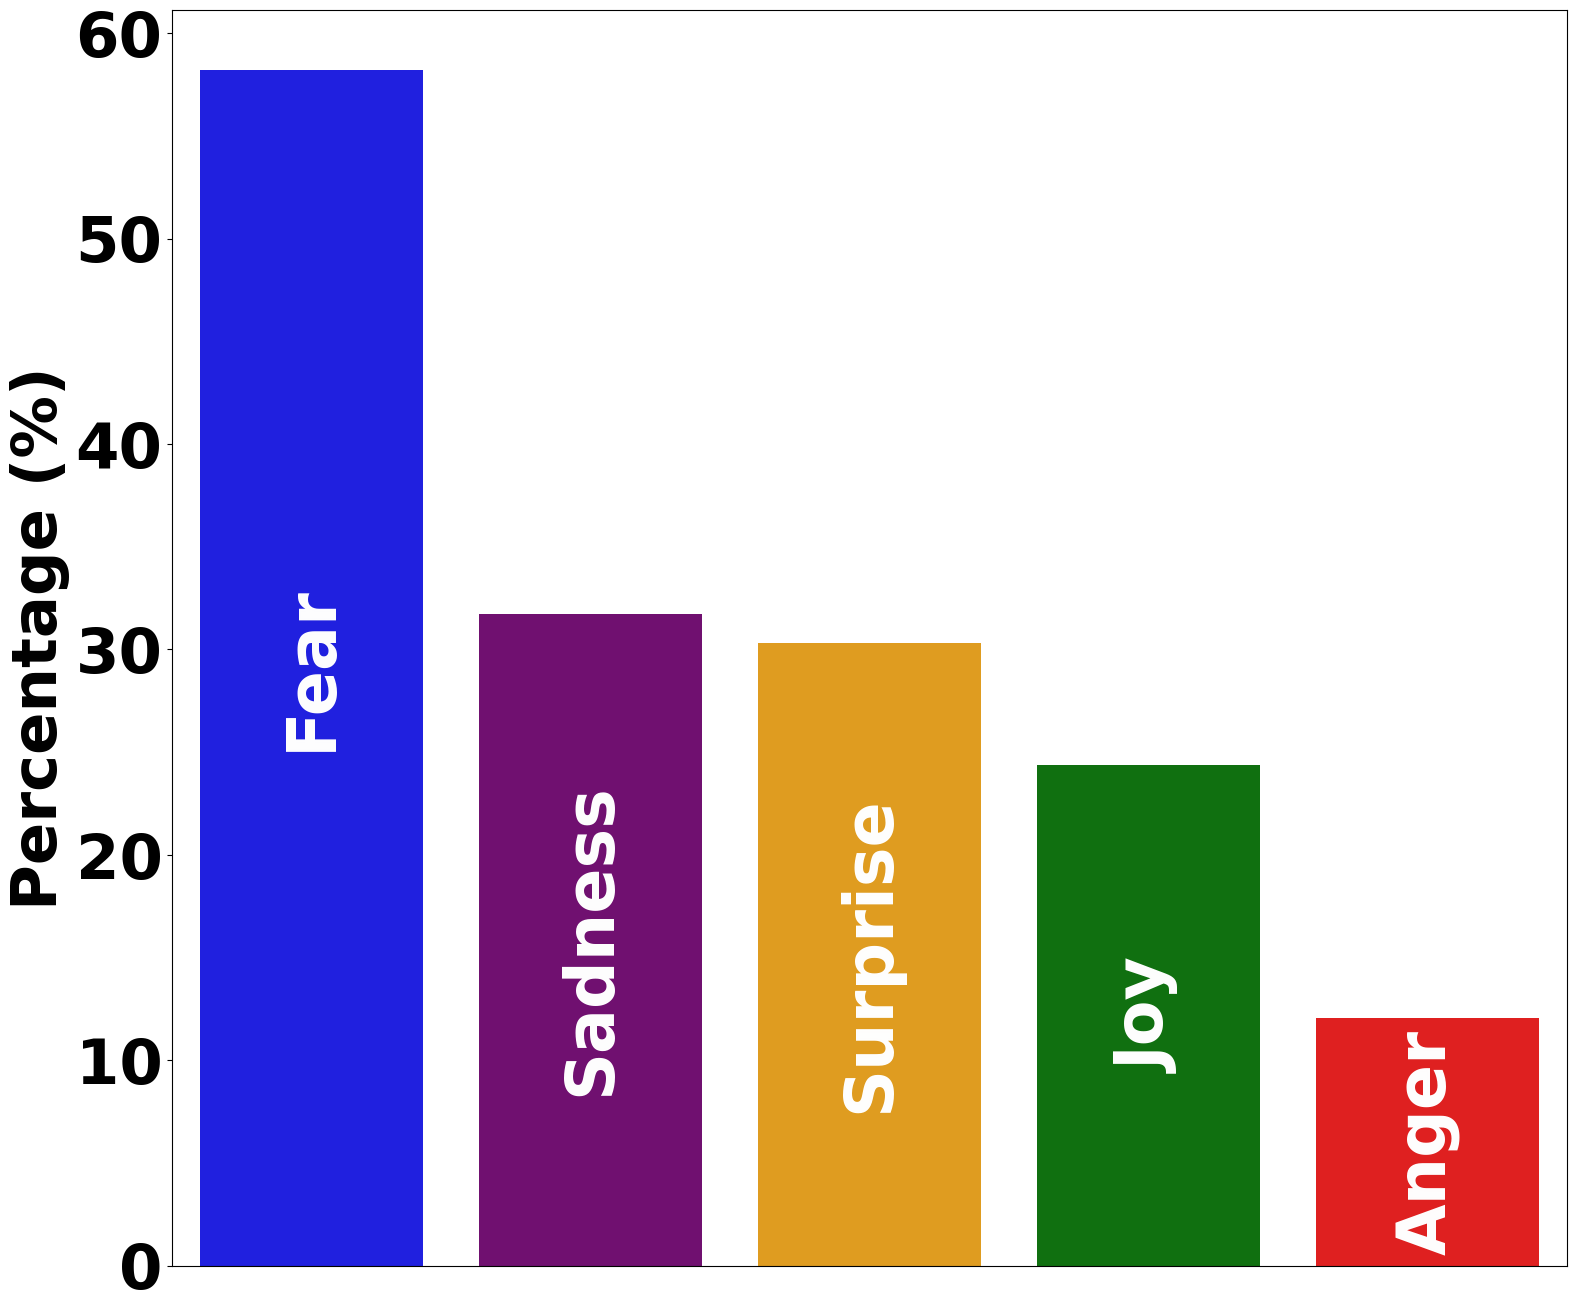

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
emotions = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
class_counts = train[emotions].sum()
normalized_counts = (class_counts / len(train)) * 100  # Convert to percentages
# Sort the normalized counts in descending order
normalized_counts = normalized_counts.sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(18, 16.3))
# Use the sorted data for plotting
ax = sns.barplot(x=normalized_counts.index, y=normalized_counts.values, 
                 palette=[emotion_colors[emotion] for emotion in normalized_counts.index])

# Add vertical labels inside bars
for i, v in enumerate(normalized_counts.values):
    ax.text(i, v/2, normalized_counts.index[i], 
            color='white', 
            ha='center',
            va='center',
            fontsize=48,
            fontweight='bold',
            rotation=90)

plt.title("")
plt.xlabel("")
plt.ylabel("Percentage (%)", fontsize=45, fontweight='bold')  # Updated y-label
plt.xticks([])
plt.yticks(fontsize=45, weight='bold')
plt.show()

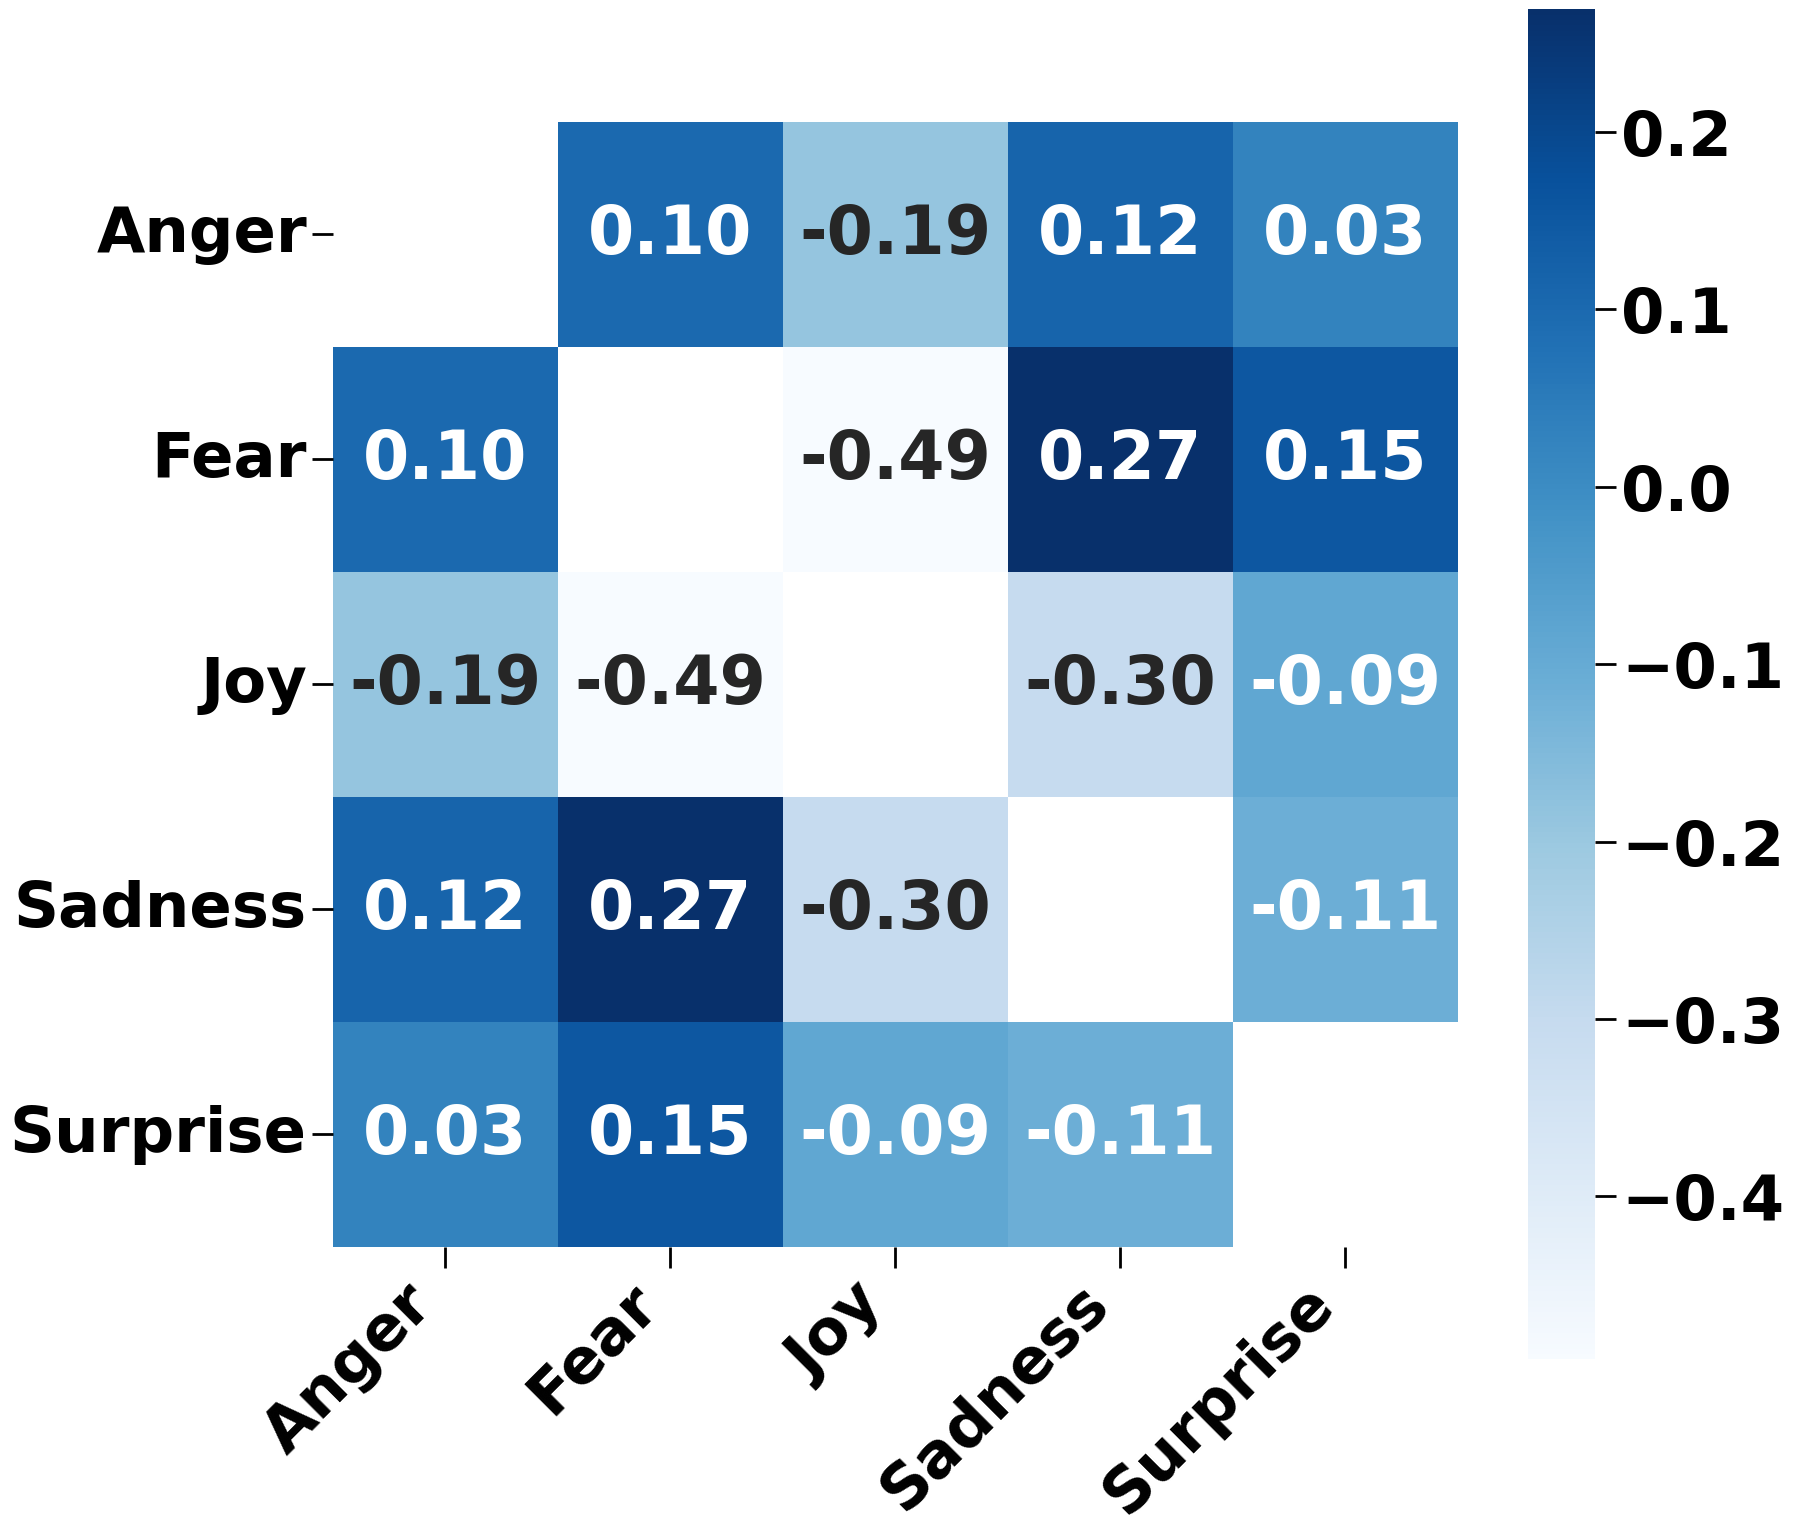

In [161]:
# Compute the correlation matrix
correlation_matrix = train[emotions].corr()

# Create a mask for the diagonal
mask = np.eye(len(correlation_matrix))

# Plot the heatmap
plt.figure(figsize=(18, 16))
hm = sns.heatmap(correlation_matrix, 
            mask=mask,  
            annot=True, 
            cmap="Blues",
            fmt=".2f",
            annot_kws={'size': 48, 'weight': 'bold'},
            cbar_kws={'label': ''},
            square=True)  # Added square=True to match co-occurrence plot

# Increase tick mark sizes and add labels
ax = plt.gca()
ax.tick_params(axis='both', which='major', length=15, width=2)

# Add ticks on both axes
plt.xticks(np.arange(len(emotions)) + 0.5, emotions, 
           fontsize=45, fontweight='bold', rotation=45, ha='right')
plt.yticks(np.arange(len(emotions)) + 0.5, emotions, 
           fontsize=45, fontweight='bold', rotation=0)

# Make the tick marks darker/bolder
for spine in ax.spines.values():
    spine.set_linewidth(10)

# Colorbar formatting
colorbar = hm.collections[0].colorbar
colorbar.ax.tick_params(labelsize=45, length=15, width=2)
plt.setp(colorbar.ax.yaxis.get_ticklabels(), weight='bold')

plt.title("")

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

### Feature Importance Evaluation on Correlation

/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_16708/1710163701.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_abs_corr.index, y=mean_abs_corr.values, palette=bar_colors)


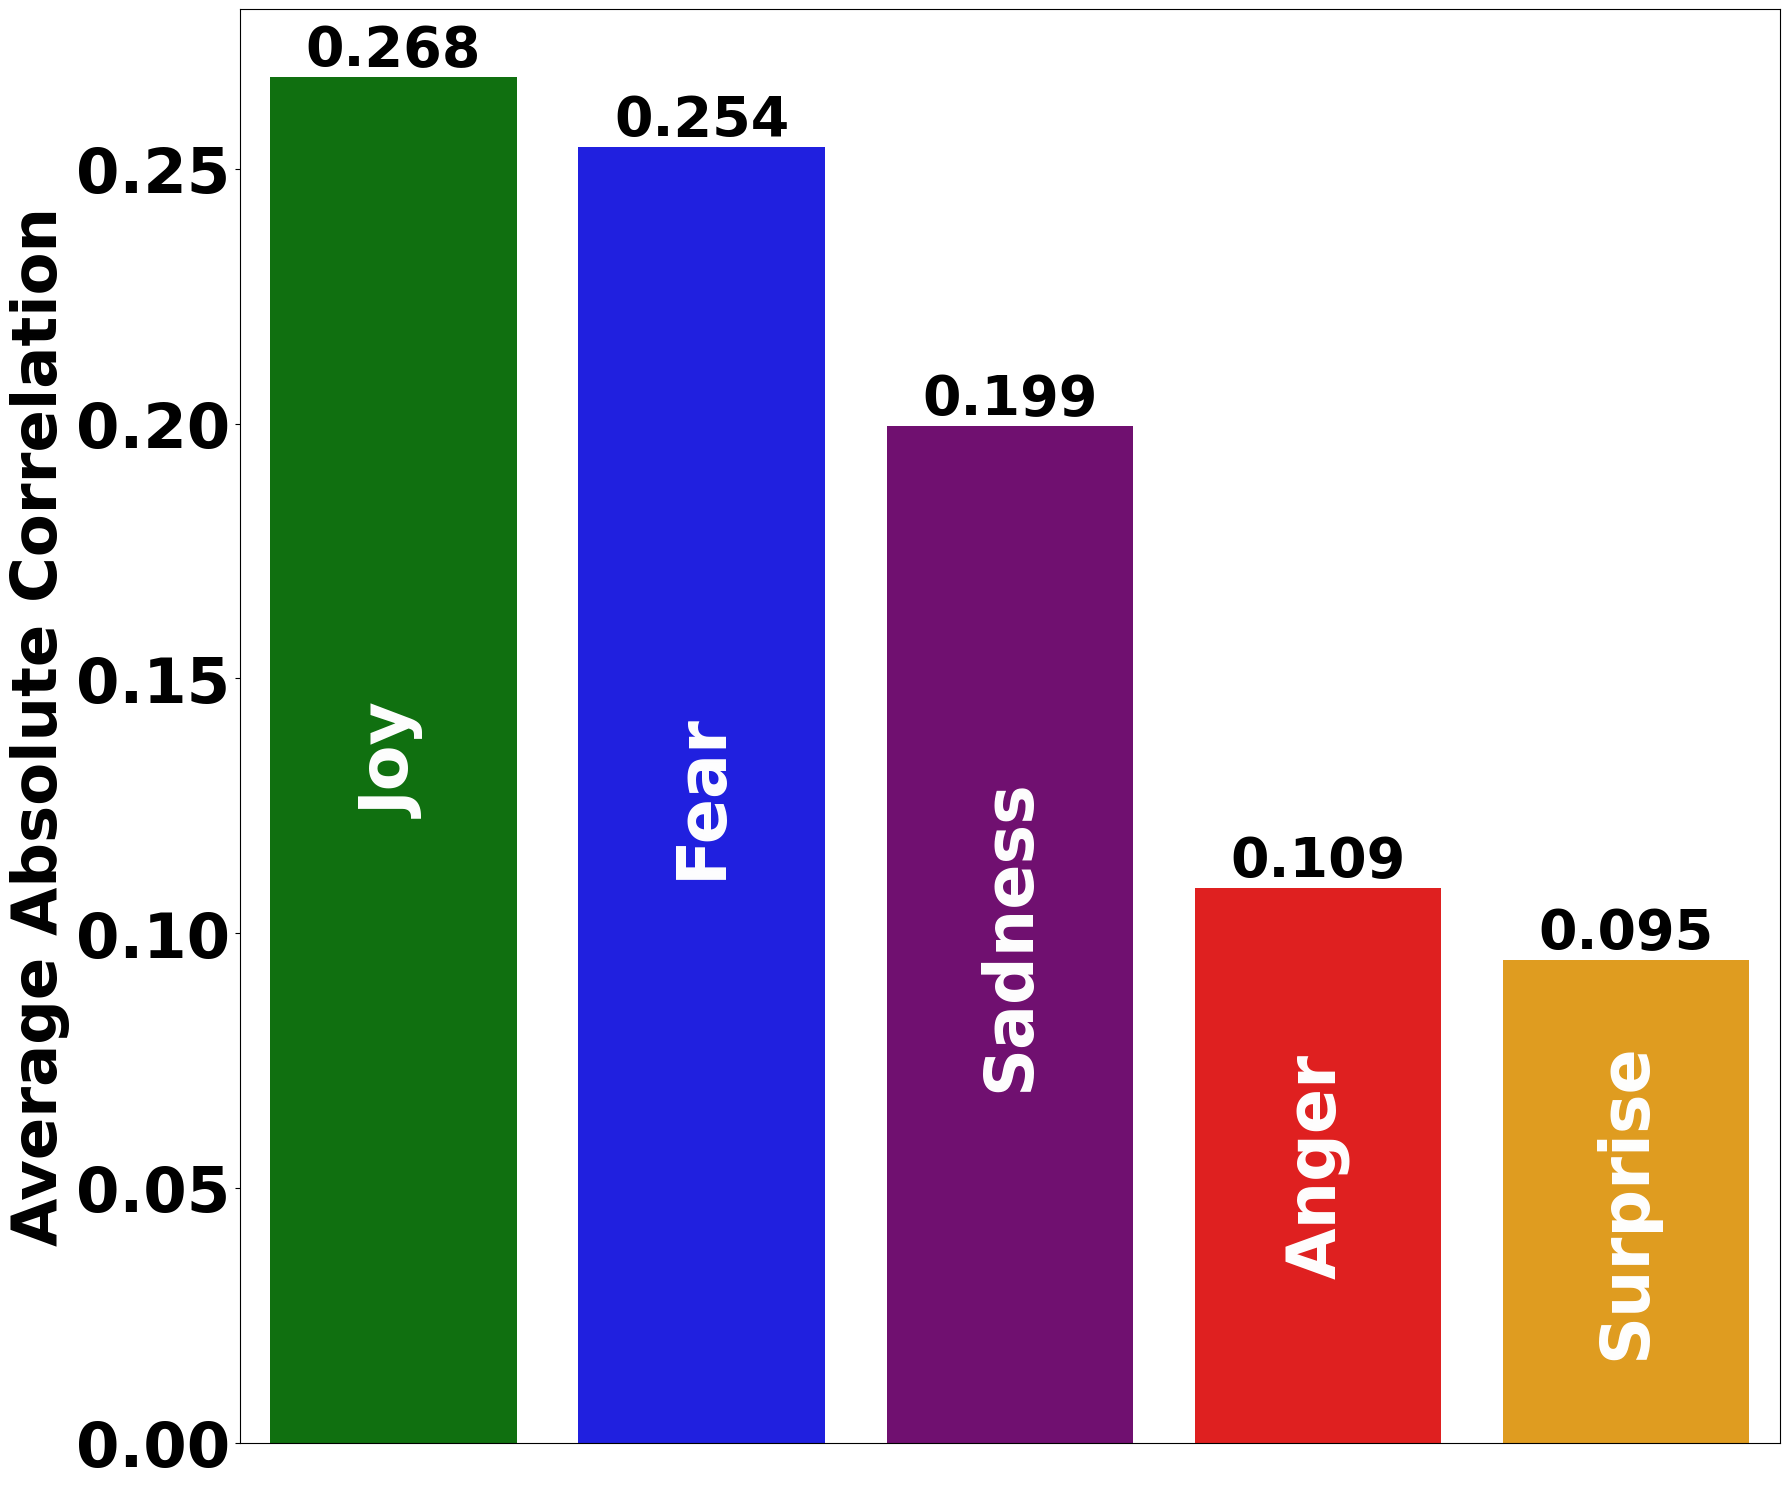


Feature Importance Analysis:

Joy:
  - Surprise: -0.087
  - Anger: -0.192
  - Sadness: -0.302
  - Fear: -0.492

Fear:
  - Sadness: 0.269
  - Surprise: 0.154
  - Anger: 0.102
  - Joy: -0.492

Sadness:
  - Fear: 0.269
  - Anger: 0.115
  - Surprise: -0.112
  - Joy: -0.302

Anger:
  - Sadness: 0.115
  - Fear: 0.102
  - Surprise: 0.027
  - Joy: -0.192

Surprise:
  - Fear: 0.154
  - Anger: 0.027
  - Joy: -0.087
  - Sadness: -0.112


In [168]:
# Correct calculation excluding diagonal
abs_corr = correlation_matrix.abs()
# Create mask for diagonal
mask = ~np.eye(len(correlation_matrix), dtype=bool)
# Calculate mean excluding diagonal
mean_abs_corr = (abs_corr * mask).sum() / (mask.sum() / len(correlation_matrix))
mean_abs_corr = pd.Series(
    {emotion: abs_corr[emotion][abs_corr.index != emotion].mean() 
     for emotion in emotions}
).sort_values(ascending=False)

# Define custom colors for each emotion (ensuring correct mapping)
emotion_colors = {
    'Joy': 'green',
    'Fear': 'blue',
    'Anger': 'red',
    'Sadness': 'purple',
    'Surprise': 'orange'
}

# Plot the distribution
plt.figure(figsize=(18, 15))
# Create list of colors in the same order as mean_abs_corr.index
bar_colors = [emotion_colors[emotion] for emotion in mean_abs_corr.index]
ax = sns.barplot(x=mean_abs_corr.index, y=mean_abs_corr.values, palette=bar_colors)

# Add vertical labels inside bars
for i, v in enumerate(mean_abs_corr.values):
    # Add emotion label inside bar
    ax.text(i, v/2, mean_abs_corr.index[i], 
            color='white', 
            ha='center',
            va='center',
            fontsize=48,
            fontweight='bold',
            rotation=90)  # Vertical text
    
    # Add value on top of bar
    ax.text(i, v, f'{v:.3f}', 
            ha='center', 
            va='bottom',
            fontsize=40, 
            fontweight='bold')

plt.xlabel("")  # Remove x-axis label
plt.ylabel("Average Absolute Correlation", fontsize=45, fontweight='bold')
plt.xticks([])  # Remove x-axis ticks
plt.yticks(fontsize=45, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nFeature Importance Analysis:")
for emotion in mean_abs_corr.index:
    print(f"\n{emotion}:")
    # Get correlations with other emotions
    correlations = correlation_matrix[emotion].drop(emotion).sort_values(ascending=False)
    for other_emotion, corr in correlations.items():
        print(f"  - {other_emotion}: {corr:.3f}")

In [149]:
# Calculate statistical significance
def correlation_significance(correlation, n_samples):
    # Calculate t-statistic
    t_stat = correlation * np.sqrt((n_samples-2)/(1-correlation**2))
    # Calculate p-value (two-tailed test)
    p_value = 2 * (1 - scipy.stats.t.cdf(abs(t_stat), n_samples-2))
    return p_value

n_samples = len(train)
significant_correlations = {}

print("Significant Correlations (p < 0.05):")
for emotion in emotions:
    correlations = correlation_matrix[emotion].drop(emotion)
    p_values = {other: correlation_significance(corr, n_samples) 
                for other, corr in correlations.items()}
    
    # Filter significant correlations
    sig_corrs = {other: (corr, p_values[other]) 
                 for other, corr in correlations.items() 
                 if p_values[other] < 0.05}
    
    if sig_corrs:
        print(f"\n{emotion}:")
        for other, (corr, p_val) in sig_corrs.items():
            print(f"  - {other}: r={corr:.3f}, p={p_val:.3e}")

Significant Correlations (p < 0.05):

Anger:
  - Fear: r=0.102, p=8.106e-08
  - Joy: r=-0.192, p=0.000e+00
  - Sadness: r=0.115, p=1.124e-09

Fear:
  - Anger: r=0.102, p=8.106e-08
  - Joy: r=-0.492, p=0.000e+00
  - Sadness: r=0.269, p=0.000e+00
  - Surprise: r=0.154, p=2.220e-16

Joy:
  - Anger: r=-0.192, p=0.000e+00
  - Fear: r=-0.492, p=0.000e+00
  - Sadness: r=-0.302, p=0.000e+00
  - Surprise: r=-0.087, p=5.027e-06

Sadness:
  - Anger: r=0.115, p=1.124e-09
  - Fear: r=0.269, p=0.000e+00
  - Joy: r=-0.302, p=0.000e+00
  - Surprise: r=-0.112, p=3.812e-09

Surprise:
  - Fear: r=0.154, p=2.220e-16
  - Joy: r=-0.087, p=5.027e-06
  - Sadness: r=-0.112, p=3.812e-09


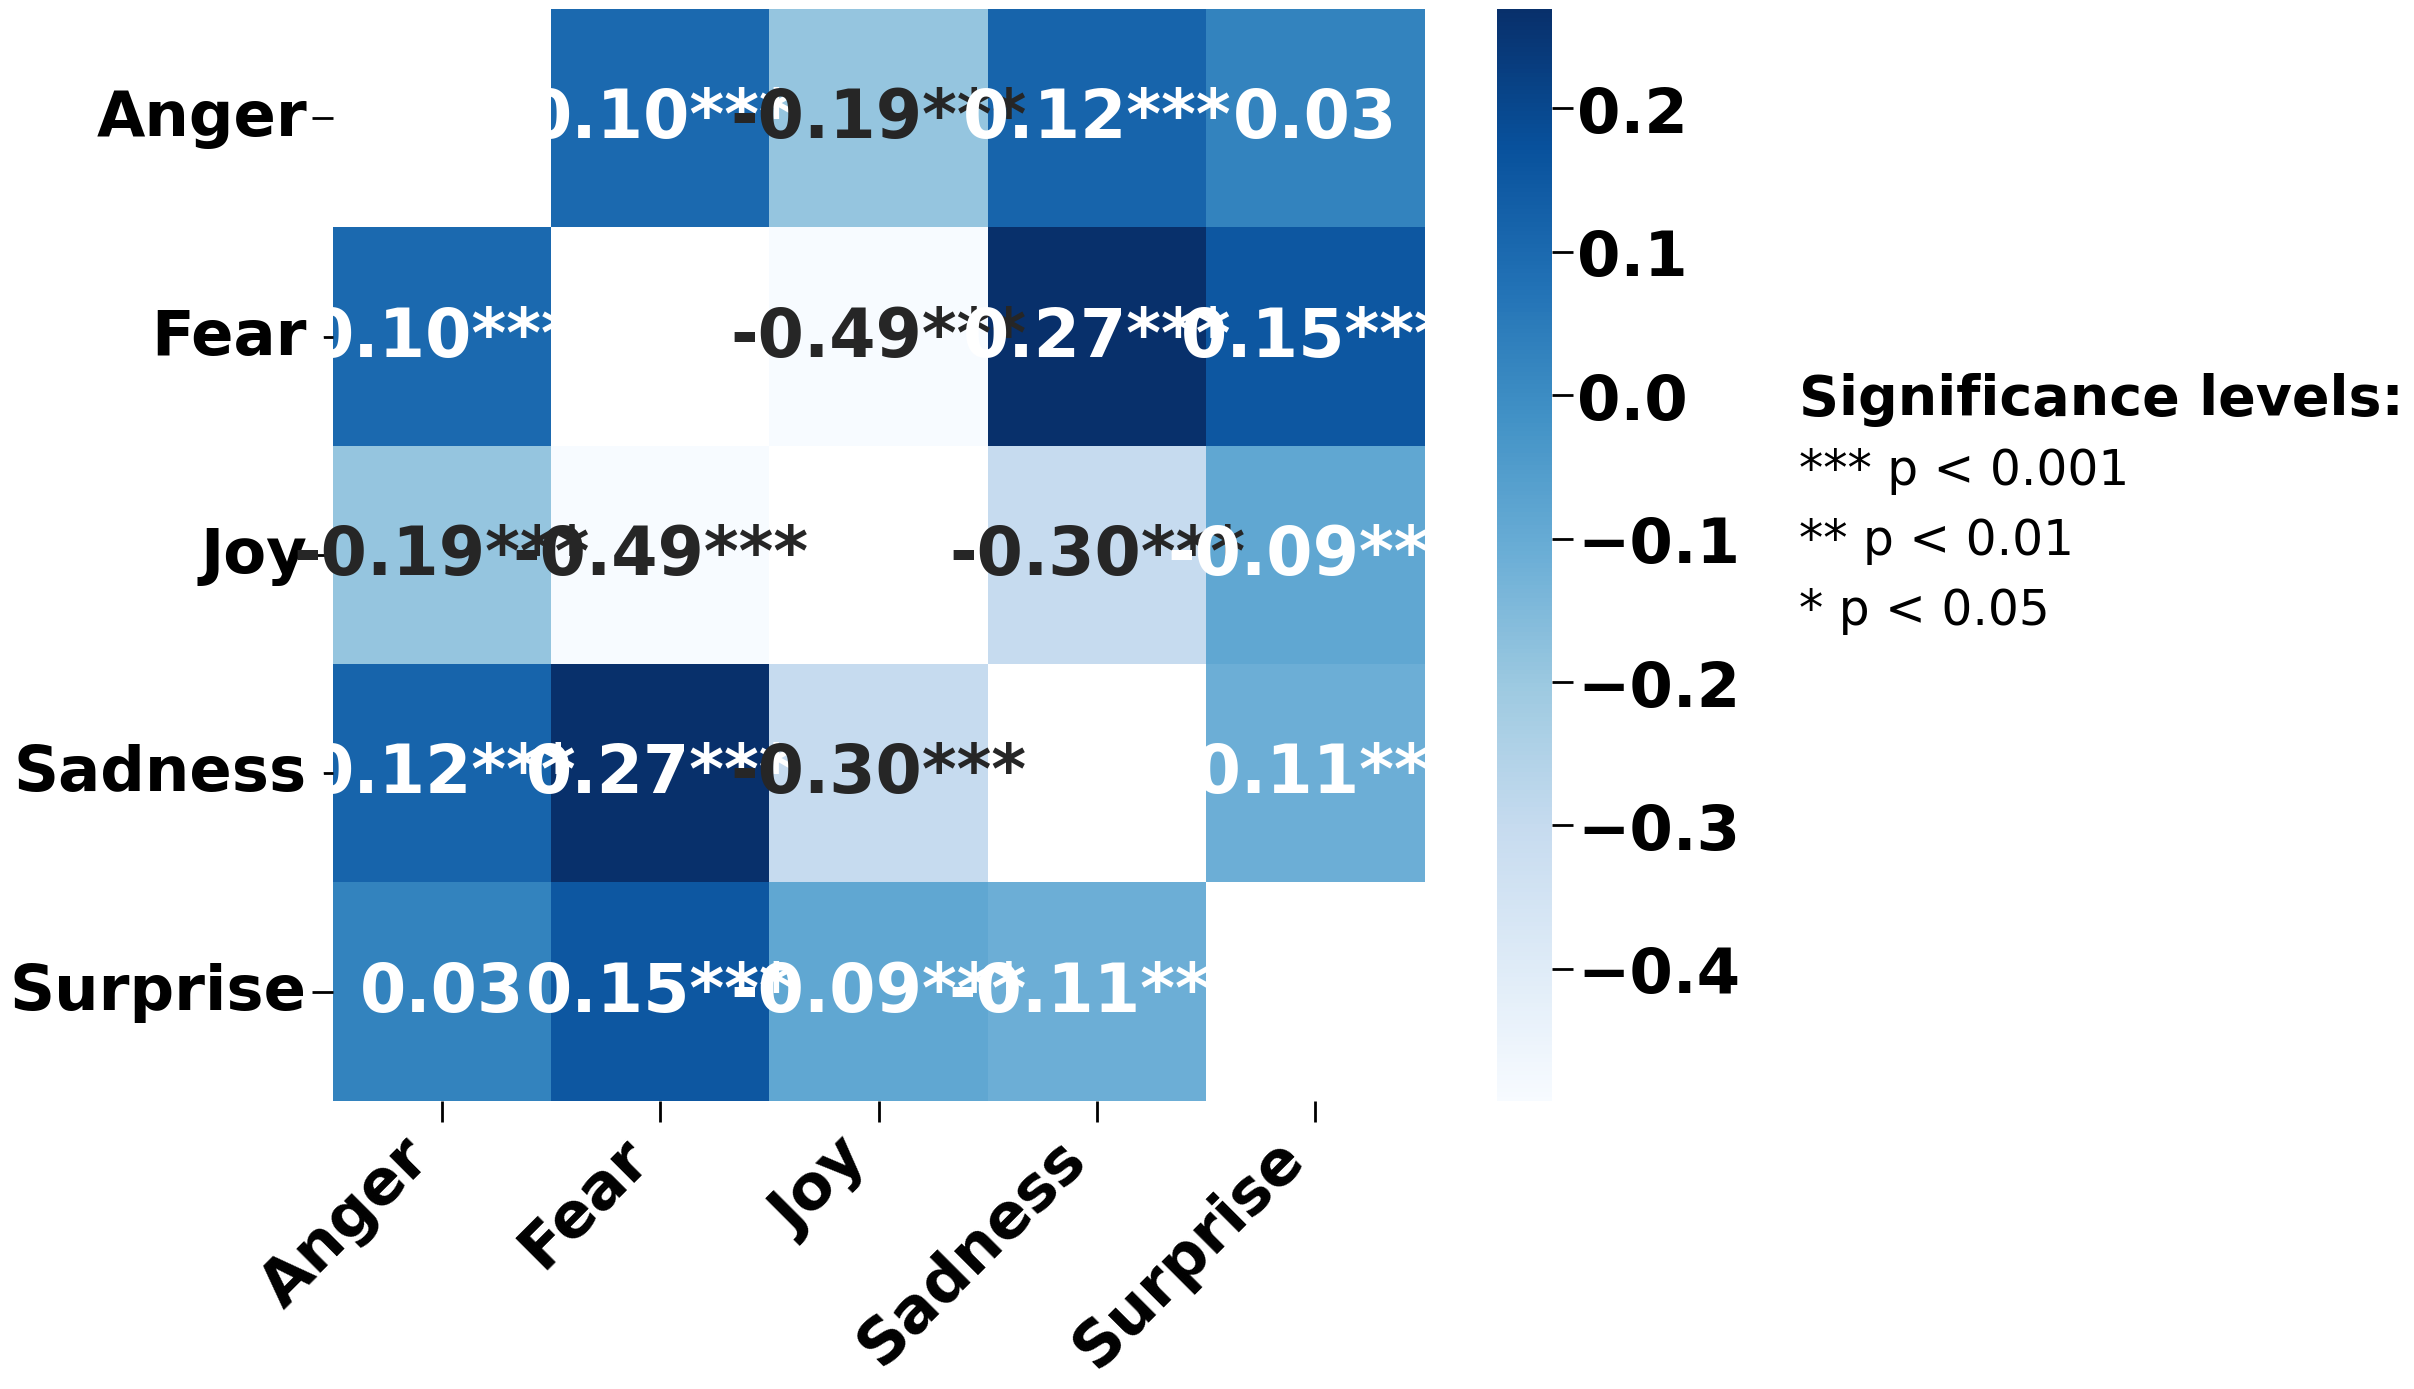

In [150]:
# Compute the correlation matrix and significance
correlation_matrix = train[emotions].corr()
n_samples = len(train)

# Function to get significance markers
def get_significance_marker(correlation, n_samples):
    p_value = correlation_significance(correlation, n_samples)
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    return ''

# Create annotation matrix with significance markers
annot_matrix = correlation_matrix.round(2).astype(str)
for i in range(len(emotions)):
    for j in range(len(emotions)):
        if i != j:  # Skip diagonal
            marker = get_significance_marker(correlation_matrix.iloc[i, j], n_samples)
            annot_matrix.iloc[i, j] = f"{correlation_matrix.iloc[i, j]:.2f}{marker}"

# Create a mask for the diagonal
mask = np.eye(len(correlation_matrix))

# Plot the heatmap
plt.figure(figsize=(18, 14))
hm = sns.heatmap(correlation_matrix, 
            mask=mask,  
            annot=annot_matrix,
            cmap="Blues",
            fmt="",
            annot_kws={'size': 48, 'weight': 'bold'},
            cbar_kws={'label': ''},
            square=True)

# Rest of formatting remains the same
ax = plt.gca()
ax.tick_params(axis='both', which='major', length=15, width=2)

plt.xticks(np.arange(len(emotions)) + 0.5, emotions, 
           fontsize=45, fontweight='bold', rotation=45, ha='right')
plt.yticks(np.arange(len(emotions)) + 0.5, emotions, 
           fontsize=45, fontweight='bold', rotation=0)

for spine in ax.spines.values():
    spine.set_linewidth(10)

colorbar = hm.collections[0].colorbar
colorbar.ax.tick_params(labelsize=45, length=15, width=2)
plt.setp(colorbar.ax.yaxis.get_ticklabels(), weight='bold')

# Add legend for significance markers
plt.figtext(1.02, 0.7, 'Significance levels:', fontsize=40, fontweight='bold')
plt.figtext(1.02, 0.65, '*** p < 0.001', fontsize=35)
plt.figtext(1.02, 0.60, '** p < 0.01', fontsize=35)
plt.figtext(1.02, 0.55, '* p < 0.05', fontsize=35)

plt.title("")
plt.tight_layout()
plt.show()

/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_16708/2827557092.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7177177177177178' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  conditional_probabilities.iloc[i] = co_occurrence.iloc[i] / co_occurrence.iloc[i, i]  # Removed * 100
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_16708/2827557092.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.021021021021021023' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  conditional_probabilities.iloc[i] = co_occurrence.iloc[i] / co_occurrence.iloc[i, i]  # Removed * 100
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_16708/2827557092.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and w

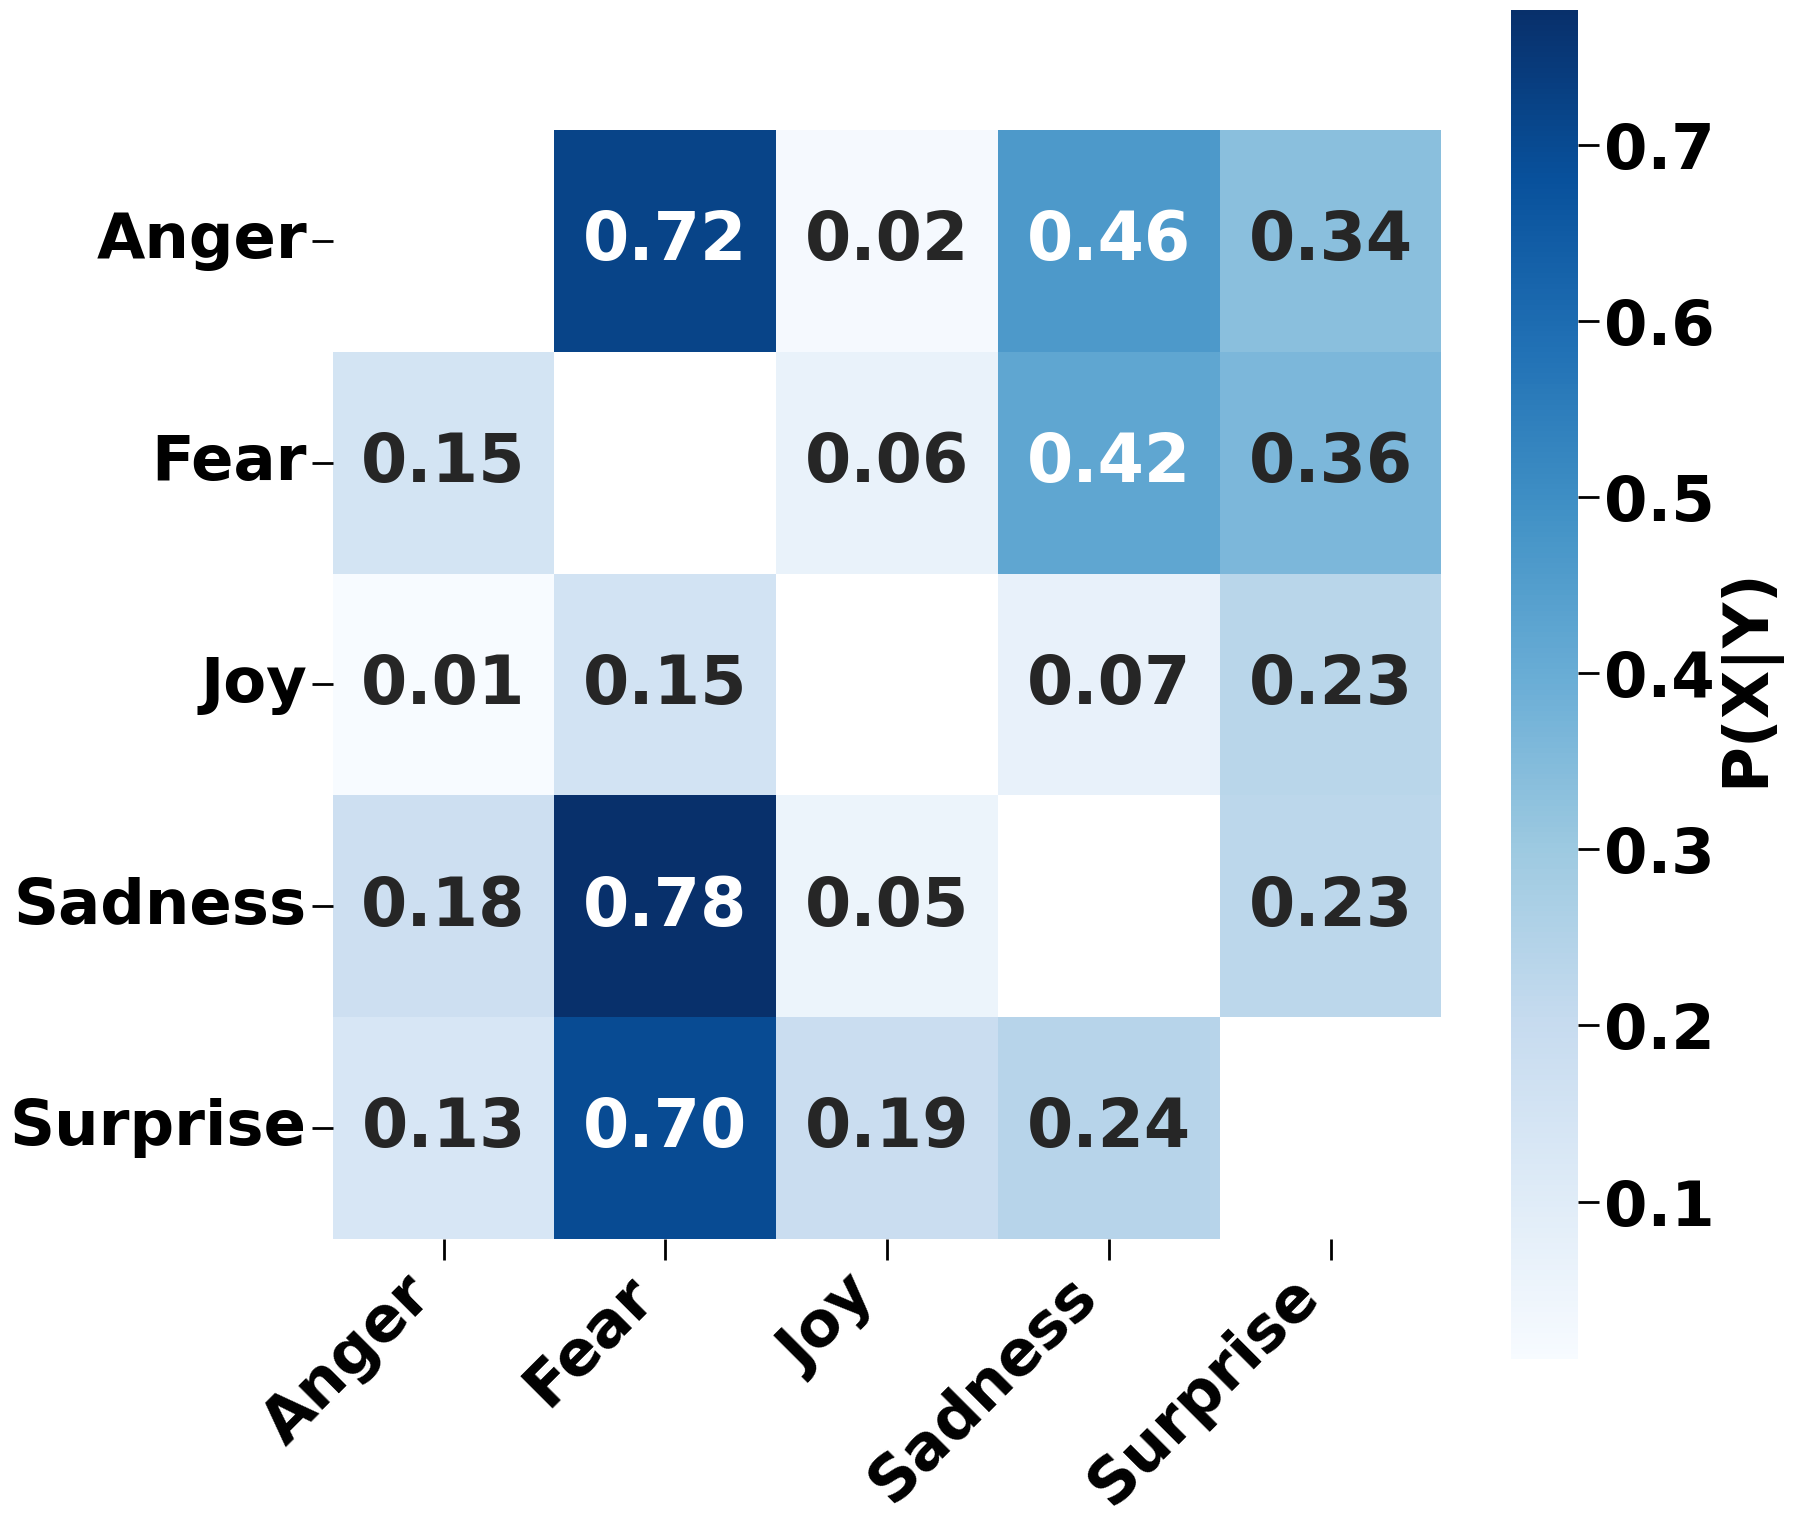

In [160]:
# Calculate conditional co-occurrence probabilities
co_occurrence = train[emotions].T.dot(train[emotions])
# For each row, divide by the diagonal element (total occurrences of that emotion)
conditional_probabilities = co_occurrence.copy()
for i in range(len(emotions)):
    conditional_probabilities.iloc[i] = co_occurrence.iloc[i] / co_occurrence.iloc[i, i]  # Removed * 100

mask = np.eye(len(emotions), dtype=bool)

plt.figure(figsize=(18, 16))
hm = sns.heatmap(conditional_probabilities, 
            mask=mask,
            annot=True, 
            cmap="Blues",
            fmt='.2f',  # Changed to 2 decimal places
            annot_kws={'size': 48, 'weight': 'bold'},
            cbar_kws={'label': 'P(X|Y)'},  # Updated label
            square=True)

# Add % to annotations after creating the heatmap
# for t in hm.texts:
#     t.set_text(t.get_text() + '%')

# Increase tick mark sizes and add labels
ax = plt.gca()
ax.tick_params(axis='both', which='major', length=15, width=2)  # Increase tick size

# Add ticks on both axes
plt.xticks(np.arange(len(emotions)) + 0.5, emotions, 
           fontsize=45, fontweight='bold', rotation=45, ha='right')
plt.yticks(np.arange(len(emotions)) + 0.5, emotions, 
           fontsize=45, fontweight='bold', rotation=0)

# Make the tick marks darker/bolder
for spine in ax.spines.values():
    spine.set_linewidth(10)  # Increase spine width

# Update colorbar label with bold and italicized variables
colorbar = hm.collections[0].colorbar
colorbar.ax.tick_params(labelsize=45, length=15, width=2)
colorbar.ax.set_ylabel(r'P($\mathbf{X}$|$\mathbf{Y}$)', fontsize=45, fontweight='bold')  # Updated LaTeX formatting
plt.setp(colorbar.ax.yaxis.get_ticklabels(), weight='bold')

plt.title("")

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()
# sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='Blues',
#             annot_kws={'size': 36, 'weight': 'bold'})
# plt.title('Co-occurrence of Emotions')
# plt.xticks(fontsize=26, fontweight='bold')  # Make x-axis labels larger and bold
# plt.yticks(fontsize=26, fontweight='bold')
# cbar = plt.gca().collections[0].colorbar
# cbar.ax.tick_params(labelsize=26)  # Add this line to adjust colorbar font size
# plt.title("")
# plt.show()